<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/feature_engineering/WI_PCA_Analysis_SupersetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**

Dimensionality Reduction using PCA on Wisconsin (WI) Superset timeseries data


## Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_Superset_dataset_Feb12.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Feb04.csv
 maryland_inertia_data_allstates_Feb05.csv
 maryland_inertia_data_allstates_Feb12.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Feb05.cs

# Import library

In [2]:
%matplotlib inline
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import matplotlib.pyplot as plt # for plotting

import seaborn as sns


# Load Superset data

In [3]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
all_states_data = pd.read_csv(location+'AllStates_Superset_dataset_Mar26.csv', low_memory=False)
all_states_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-01,Alabama,1001,0,Autauga County,0.0,7.194,49,15.0,13.0,0.0,0.0,3.0,0.0,35.853419,Alabama,35,22,2.81,41.6,1.0,32.9,0.26,2.55,0,55601,-1.2,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,37,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
1,2020-03-02,Alabama,1001,0,Autauga County,0.0,14.587,100,15.0,4.0,0.0,0.0,5.0,-1.0,35.853419,Alabama,11,13,3.33,40.9,0.5,42.0,0.80,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,38,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0


In [5]:
CA_superset_data = all_states_data[all_states_data['Province_State'] == 'Wisconsin']
CA_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
44512,2020-03-01,Wisconsin,55053,0,Jackson County,0.0,2.500,30,22.0,0.0,0.0,23.0,11.0,0.0,8.019932,Wisconsin,27,19,3.27,45.0,7.6,40.7,0.34,2.94,0,20478,3.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,37,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,41.305451
44513,2020-03-02,Wisconsin,55053,0,Jackson County,0.0,8.198,99,0.0,4.0,0.0,14.0,4.0,0.0,8.019932,Wisconsin,19,18,3.44,40.1,6.1,51.1,0.53,2.91,0,20478,2.1,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,38,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,35.831235
44514,2020-03-03,Wisconsin,55053,0,Jackson County,0.0,5.540,67,11.0,6.0,0.0,22.0,3.0,0.0,8.019932,Wisconsin,16,18,3.76,40.0,6.8,57.8,0.50,3.26,0,20478,14.4,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,39,41.3,0.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,27.371082
44515,2020-03-04,Wisconsin,55053,0,Jackson County,0.0,8.236,100,10.0,2.0,0.0,6.0,4.0,0.0,8.019932,Wisconsin,14,17,3.65,38.7,7.2,57.4,0.65,3.00,0,20478,5.3,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,40,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,18.413273
44516,2020-03-05,Wisconsin,55053,0,Jackson County,0.0,11.741,142,19.0,-4.0,0.0,1.0,2.0,0.0,8.019932,Wisconsin,12,16,3.55,42.6,6.6,54.9,0.58,2.97,0,20478,4.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,41,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,12.441401


In [6]:
print(CA_superset_data.shape)
print(CA_superset_data.Date.min())
print(CA_superset_data.Date.max())


(17862, 56)
2020-03-01
2020-12-28


## Factor Plot

In [7]:
df_superset_data_filtered1 = CA_superset_data[(CA_superset_data['Date'] >= '2020-04-01') & (CA_superset_data['Date'] < '2020-07-01')]
print(df_superset_data_filtered1.shape)


(5660, 56)


## Preprocessing: Convert 'date' as index column before applying PCA

In [8]:
CA_superset_data['Date'] = pd.to_datetime(CA_superset_data['Date'], format='%Y-%m-%d') 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
CA_superset_data = CA_superset_data.set_index('Date')
CA_superset_data.head()

,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,Wisconsin,55053,0,Jackson County,0.0,2.500,30,22.0,0.0,0.0,23.0,11.0,0.0,8.019932,Wisconsin,27,19,3.27,45.0,7.6,40.7,0.34,2.94,0,20478,3.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,37,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,41.305451
2020-03-02,Wisconsin,55053,0,Jackson County,0.0,8.198,99,0.0,4.0,0.0,14.0,4.0,0.0,8.019932,Wisconsin,19,18,3.44,40.1,6.1,51.1,0.53,2.91,0,20478,2.1,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,38,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,35.831235
2020-03-03,Wisconsin,55053,0,Jackson County,0.0,5.540,67,11.0,6.0,0.0,22.0,3.0,0.0,8.019932,Wisconsin,16,18,3.76,40.0,6.8,57.8,0.50,3.26,0,20478,14.4,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,39,41.3,0.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,27.371082
2020-03-04,Wisconsin,55053,0,Jackson County,0.0,8.236,100,10.0,2.0,0.0,6.0,4.0,0.0,8.019932,Wisconsin,14,17,3.65,38.7,7.2,57.4,0.65,3.00,0,20478,5.3,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,40,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,18.413273
2020-03-05,Wisconsin,55053,0,Jackson County,0.0,11.741,142,19.0,-4.0,0.0,1.0,2.0,0.0,8.019932,Wisconsin,12,16,3.55,42.6,6.6,54.9,0.58,2.97,0,20478,4.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,41,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,12.441401


## Group the data

In [10]:
CA_superset_data.columns

Index(['Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tracing.wo

In [11]:
x_col_demographics = ['FIPS','PopDensity','X..people.older.than.60',
                      'Median.income', 'X..African.Americans',
                      'X..Hispanic.Americans', 'X..Male','New Cases/100k population']

In [12]:
#['growth_code', 'positivity_rate']
x_col_hospitalization_testing = ['Hospital.beds.1000.people',
       'ICUs.1000.people', 
       'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage',#'positivity_rate',
       'rolling_avg_new_cases/100k'	#,'growth_code'
       ,'New Cases/100k population'] #'X..contact.tracing.workers.1000.people',

In [13]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home','New Cases/100k population']

In [14]:
x_col_socialdistancing = ['m50', 'm50_index','Social.distancing.index','New Cases/100k population']

In [15]:
x_col_maskrule = ['mask_rule_severity','New Cases/100k population']

# PCA: Demographic Group

In [16]:
CA_superset_data_filtered = CA_superset_data[x_col_demographics]
CA_superset_data_filtered.head()

,FIPS,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,New Cases/100k population
Date,,,,,,,,
2020-03-01,55053,8.019932,26,52984,2.1,3.3,53.42,0.0
2020-03-02,55053,8.019932,26,52984,2.1,3.3,53.42,0.0
2020-03-03,55053,8.019932,26,52984,2.1,3.3,53.42,0.0
2020-03-04,55053,8.019932,26,52984,2.1,3.3,53.42,0.0
2020-03-05,55053,8.019932,26,52984,2.1,3.3,53.42,0.0


In [17]:
print(CA_superset_data_filtered.shape)
CA_superset_data_filtered = CA_superset_data_filtered.dropna()
print(CA_superset_data_filtered.shape)

(17862, 8)
(17862, 8)


## Correlation Plot

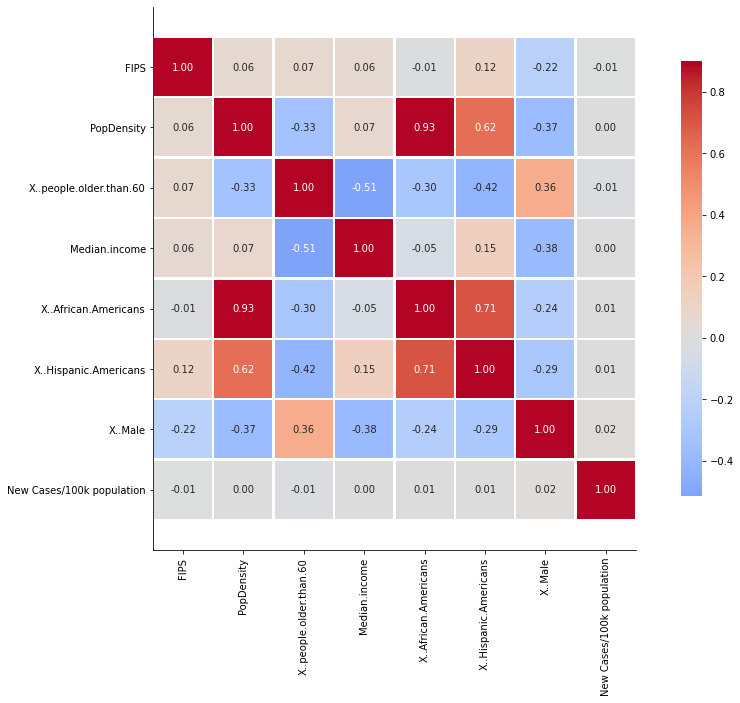

In [18]:

corr = CA_superset_data_filtered.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

## Standardizing the data

In [19]:
X = CA_superset_data_filtered.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

## Apply PCA

In [20]:
pca = PCA()
X_pca = pca.fit(X_std)

## Determine the number of components

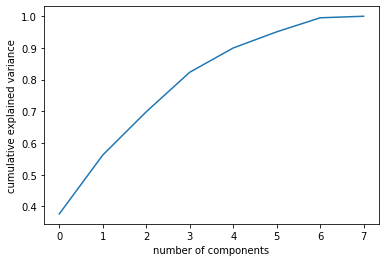

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Dimensionality Reduction

In [22]:
num_components = 6
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

## Important feature set

In [23]:
pd.DataFrame(pca.components_, columns = CA_superset_data_filtered.columns)


,FIPS,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,New Cases/100k population
0,0.069051,0.503285,-0.362409,0.198086,0.490742,0.471522,-0.328911,0.003685
1,-0.121929,0.280640,0.393507,-0.664675,0.391981,0.147437,0.366297,0.013183
2,0.876304,0.024970,0.336197,-0.129589,-0.046343,0.015551,-0.274881,-0.153943
3,0.156582,-0.005773,0.031911,-0.004593,-0.015531,0.011457,-0.009579,0.986887
4,-0.367715,0.168144,0.301085,-0.171086,0.020201,-0.372728,-0.758376,0.046079
5,-0.010901,0.347317,0.516434,0.659370,0.191838,-0.259647,0.271220,-0.001203


In [24]:

n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = CA_superset_data_filtered.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [25]:
most_important_names

['PopDensity',
 'Median.income',
 'FIPS',
 'New Cases/100k population',
 'X..Male',
 'Median.income']

In [26]:
print(" initial_feature_names : ",initial_feature_names)

print("most_important_names: ", most_important_names)

print(len(initial_feature_names) - len(most_important_names))

 initial_feature_names :  Index(['FIPS', 'PopDensity', 'X..people.older.than.60', 'Median.income',
       'X..African.Americans', 'X..Hispanic.Americans', 'X..Male',
       'New Cases/100k population'],
      dtype='object')
most_important_names:  ['PopDensity', 'Median.income', 'FIPS', 'New Cases/100k population', 'X..Male', 'Median.income']
2


# PCA: Hospitalization and testing  Group

In [27]:
CA_superset_data_filtered = CA_superset_data[x_col_hospitalization_testing]
CA_superset_data_filtered.head()

,Hospital.beds.1000.people,ICUs.1000.people,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,rolling_avg_new_cases/100k,New Cases/100k population
Date,,,,,,,,,
2020-03-01,3.01,0.27,41.3,0.0,0.0,0.0,0,41.305451,0.0
2020-03-02,3.01,0.27,41.3,0.0,0.0,0.0,0,35.831235,0.0
2020-03-03,3.01,0.27,41.3,0.0,0.0,0.0,0,27.371082,0.0
2020-03-04,3.01,0.27,41.3,5.0,0.0,0.0,0,18.413273,0.0
2020-03-05,3.01,0.27,41.3,5.0,0.0,0.0,0,12.441401,0.0


In [28]:
print(CA_superset_data_filtered.shape)
CA_superset_data_filtered = CA_superset_data_filtered.dropna()
print(CA_superset_data_filtered.shape)

(17862, 9)
(17862, 9)


## Correlation Plot

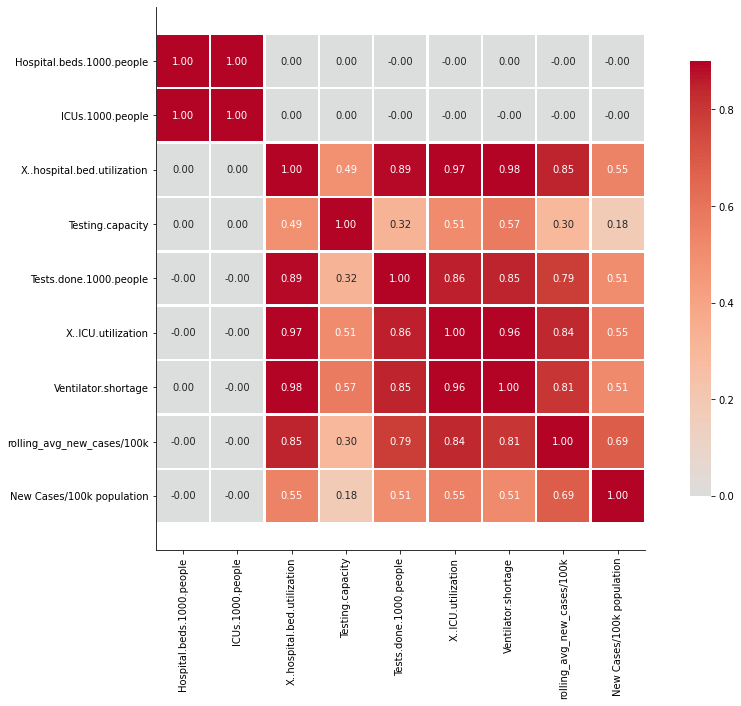

In [29]:

corr = CA_superset_data_filtered.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

## Standardizing the data

In [30]:
X = CA_superset_data_filtered.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

## Apply PCA

In [31]:
pca = PCA()
X_pca = pca.fit(X_std)

## Determine the number of components

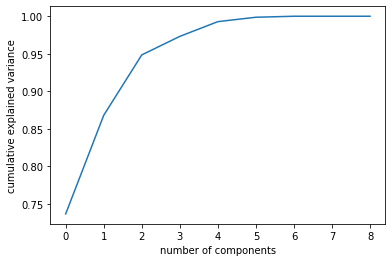

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Dimensionality Reduction

In [33]:
num_components = 5
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

## Important feature set

In [34]:
pd.DataFrame(pca.components_, columns = CA_superset_data_filtered.columns)


,Hospital.beds.1000.people,ICUs.1000.people,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,rolling_avg_new_cases/100k,New Cases/100k population
0,0.0,0.000000e+00,0.430813,0.232340,0.395503,0.426719,0.425905,0.395884,0.289460
1,-0.0,8.120674e-17,-0.044772,-0.791311,0.101525,-0.063600,-0.154054,0.274215,0.508472
2,0.0,1.336279e-17,0.190606,-0.489356,0.362851,0.134322,0.133952,-0.026492,-0.745555
3,0.0,2.289570e-16,0.023535,-0.035400,-0.640255,0.100935,0.027201,0.704629,-0.284317
4,-0.0,1.500701e-16,-0.260066,0.274611,0.530809,-0.372313,-0.388006,0.515208,-0.143492


In [35]:

n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = CA_superset_data_filtered.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [36]:
most_important_names

['X..hospital.bed.utilization',
 'Testing.capacity',
 'New Cases/100k population',
 'rolling_avg_new_cases/100k',
 'Tests.done.1000.people']

In [37]:
print(" initial_feature_names : ",initial_feature_names)

print("most_important_names: ", most_important_names)

print(len(initial_feature_names) - len(most_important_names))

 initial_feature_names :  Index(['Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'rolling_avg_new_cases/100k', 'New Cases/100k population'],
      dtype='object')
most_important_names:  ['X..hospital.bed.utilization', 'Testing.capacity', 'New Cases/100k population', 'rolling_avg_new_cases/100k', 'Tests.done.1000.people']
4


# PCA: Mobility Group

In [38]:
CA_superset_data_filtered = CA_superset_data[x_col_mobility]
CA_superset_data_filtered.head()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..working.from.home,New Cases/100k population
Date,,,,,,,,,,,,,,,
2020-03-01,22.0,0.0,0.0,23.0,11.0,0.0,19,3.27,45.0,7.6,40.7,0.34,2.94,4.5,0.0
2020-03-02,0.0,4.0,0.0,14.0,4.0,0.0,18,3.44,40.1,6.1,51.1,0.53,2.91,4.5,0.0
2020-03-03,11.0,6.0,0.0,22.0,3.0,0.0,18,3.76,40.0,6.8,57.8,0.50,3.26,4.5,0.0
2020-03-04,10.0,2.0,0.0,6.0,4.0,0.0,17,3.65,38.7,7.2,57.4,0.65,3.00,4.5,0.0
2020-03-05,19.0,-4.0,0.0,1.0,2.0,0.0,16,3.55,42.6,6.6,54.9,0.58,2.97,4.5,0.0


In [39]:
print(CA_superset_data_filtered.shape)
CA_superset_data_filtered = CA_superset_data_filtered.dropna()
print(CA_superset_data_filtered.shape)

(17862, 15)
(17862, 15)


## Correlation Plot

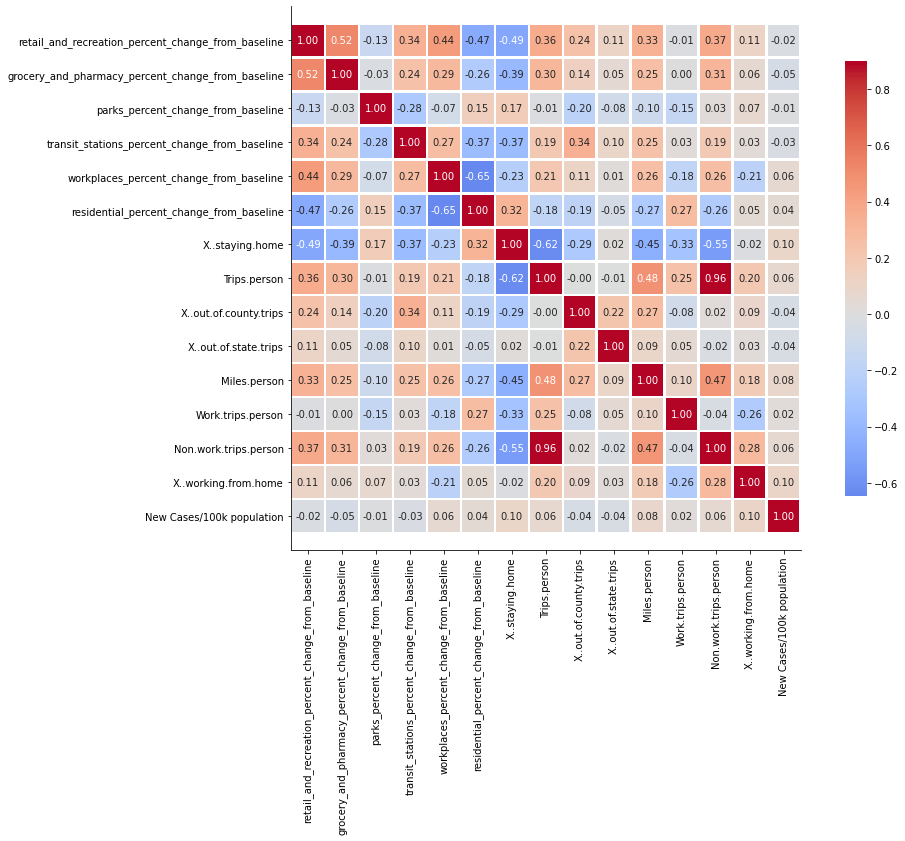

In [40]:

corr = CA_superset_data_filtered.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

## Standardizing the data

In [41]:
X = CA_superset_data_filtered.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

## Apply PCA

In [42]:
pca = PCA()
X_pca = pca.fit(X_std)

## Determine the number of components

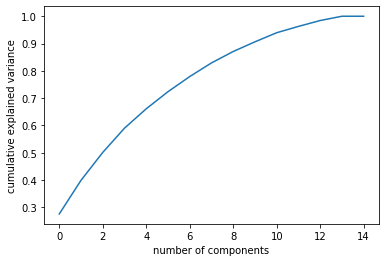

In [43]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Dimensionality Reduction

In [44]:
num_components = 12
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

## Important feature set

In [45]:
pd.DataFrame(pca.components_, columns = CA_superset_data_filtered.columns)


,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..working.from.home,New Cases/100k population
0,0.358589,0.285012,-0.103498,0.265300,0.270715,-0.294163,-0.379044,0.362887,0.172334,0.051858,0.318225,0.029901,0.365572,0.075581,0.000875
1,-0.142641,-0.051381,0.219662,-0.255018,-0.325181,0.376296,-0.137662,0.438667,-0.287794,-0.157005,0.122075,0.270306,0.373510,0.234163,0.123378
2,0.059117,0.049920,0.399399,-0.180381,0.228149,-0.228729,0.258571,0.005647,-0.187348,-0.191922,-0.038763,-0.633104,0.190793,0.321817,0.128342
3,0.027660,0.078243,0.110448,-0.138104,0.354309,-0.170574,-0.083270,0.070001,-0.462740,-0.376952,-0.163924,0.218712,0.008473,-0.599707,-0.068774
4,0.122943,0.295837,0.339871,-0.084594,-0.173879,0.080937,-0.114845,-0.017549,0.031574,0.124344,-0.151018,-0.057462,-0.001352,0.026921,-0.825301
5,-0.106555,-0.160811,-0.348232,0.275572,-0.168339,-0.034406,-0.139025,-0.016975,0.063529,-0.752880,-0.089371,-0.157315,0.028454,0.196876,-0.270691
6,-0.356563,-0.650877,-0.053024,-0.037956,0.153505,-0.216481,0.024376,0.205494,-0.004699,0.269290,0.183929,-0.125245,0.248514,-0.146840,-0.355448
7,0.140862,0.112690,-0.568091,0.020530,-0.050077,-0.069067,0.164033,0.106689,-0.555562,0.308484,-0.347624,-0.047176,0.123876,0.217047,-0.096996
8,-0.095625,-0.126867,0.406026,0.741743,-0.057099,-0.006435,-0.024214,0.100935,-0.091052,0.122708,-0.439061,0.062294,0.085973,-0.012114,0.134551
9,0.013820,-0.013552,-0.130100,-0.325144,0.003541,0.091080,-0.169991,0.205948,0.471777,0.020224,-0.629871,-0.193908,0.269038,-0.214712,0.146824


In [46]:

n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = CA_superset_data_filtered.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [47]:
most_important_names

['X..staying.home',
 'Trips.person',
 'Work.trips.person',
 'X..working.from.home',
 'New Cases/100k population',
 'X..out.of.state.trips',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'Miles.person',
 'retail_and_recreation_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline']

In [48]:
print(" initial_feature_names : ",initial_feature_names)

print("most_important_names: ", most_important_names)

print(len(initial_feature_names) - len(most_important_names))

 initial_feature_names :  Index(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'X..staying.home',
       'Trips.person', 'X..out.of.county.trips', 'X..out.of.state.trips',
       'Miles.person', 'Work.trips.person', 'Non.work.trips.person',
       'X..working.from.home', 'New Cases/100k population'],
      dtype='object')
most_important_names:  ['X..staying.home', 'Trips.person', 'Work.trips.person', 'X..working.from.home', 'New Cases/100k population', 'X..out.of.state.trips', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'Miles.person', 'retail_and_recreation_percent_change_from_baseline', 'retail_and_recreation_percent_change_

# Conclusion for superset dataset analysis:

From the above PCA analysis, we can drop the following columns from Time-series forecasting

1. Demographic Group:
>* 'X..people.older.than.60', 
>* 'Median.income', 
>* 'X..Male', 
>* 'New cases/100k',
>* 'FIPS', 
>* 'X..African.Americans', 
>* 'PopDensity'

2. Hospitalization and testing Group:
>* 'X..hospital.bed.utilization',
>* 'positivity_rate',
>* 'Ventilator.shortage',
>* 'positivity_rate',
>* 'Testing.capacity',
>* 'growth_code',
>* 'rolling_avg_new_cases/100k'

3. Mobility Group:
>* 'retail_and_recreation_percent_change_from_baseline',
>* 'Trips.person',
>* 'X..working.from.home',
>* 'parks_percent_change_from_baseline',
>* 'X..out.of.county.trips',
>* 'New cases/100k',
>* 'X..out.of.state.trips',
>* 'X..working.from.home',
>* 'Miles.person',
>* 'grocery_and_pharmacy_percent_change_from_baseline',
>* 'transit_stations_percent_change_from_baseline',
>* 'retail_and_recreation_percent_change_from_baseline'

# Applying for the whole dataset

## Standardizing the data

In [49]:
CA_superset_data.head(2)

,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,Wisconsin,55053,0,Jackson County,0.0,2.500,30,22.0,0.0,0.0,23.0,11.0,0.0,8.019932,Wisconsin,27,19,3.27,45.0,7.6,40.7,0.34,2.94,0,20478,3.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,37,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,41.305451
2020-03-02,Wisconsin,55053,0,Jackson County,0.0,8.198,99,0.0,4.0,0.0,14.0,4.0,0.0,8.019932,Wisconsin,19,18,3.44,40.1,6.1,51.1,0.53,2.91,0,20478,2.1,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,38,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,35.831235


In [50]:
numeric_cols = ['FIPS','mask_rule_severity','m50_index','retail_and_recreation_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
                'residential_percent_change_from_baseline','PopDensity','Social.distancing.index',
                'X..staying.home','Trips.person','X..out.of.county.trips',	'X..out.of.state.trips',
                'Miles.person',	'Work.trips.person','Non.work.trips.person','X..change.in.consumption',
                'Transit.mode.share','X..people.older.than.60',	'Median.income',	'X..African.Americans',
                'X..Hispanic.Americans',	'X..Male','Employment.density',	'X..hot.spots.1000.people',
                'Hospital.beds.1000.people',	'ICUs.1000.people',
                'New.cases.1000.people',	'Active.cases.1000.people',	'X.days..decreasing.COVID.cases',
                'X..hospital.bed.utilization',	'Testing.capacity',	'Tests.done.1000.people',	'X..ICU.utilization',
                'Ventilator.shortage',	'Imported.COVID.cases',	'COVID.exposure.1000.people',	'X.days..decreasing.ILI.cases',
                'Unemployment.claims.1000.people',	'Unemployment.rate',	'X..working.from.home',
                'Cumulative.inflation.rate'	,'COVID.death.rate' ,#'growth_code',
                #'New cases/100k',	'positivity_rate',	
                'New Cases/100k population',
                'rolling_avg_new_cases/100k']

In [51]:
CA_superset_data_filtered = CA_superset_data[numeric_cols]

In [52]:
CA_superset_data_filtered.head(2)

,FIPS,mask_rule_severity,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,55053,0.0,30,22.0,0.0,0.0,23.0,11.0,0.0,8.019932,27,19,3.27,45.0,7.6,40.7,0.34,2.94,3.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.0,0.0,37,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,41.305451
2020-03-02,55053,0.0,99,0.0,4.0,0.0,14.0,4.0,0.0,8.019932,19,18,3.44,40.1,6.1,51.1,0.53,2.91,2.1,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.0,0.0,38,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,35.831235


In [53]:
print(CA_superset_data_filtered.shape)
CA_superset_data_filtered = CA_superset_data_filtered.dropna()
print(CA_superset_data_filtered.shape)

(17862, 47)
(17862, 47)


In [54]:
X = CA_superset_data_filtered.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

## Apply PCA

In [55]:
pca = PCA()
X_pca = pca.fit(X_std)

## Determine the number of components

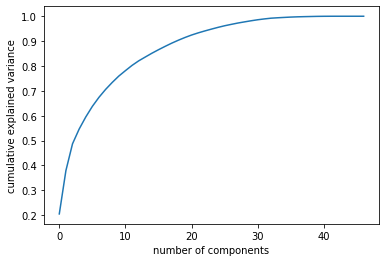

In [56]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Dimensionality Reduction

In [57]:
num_components = 30
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

## Important feature set

In [58]:
pd.DataFrame(pca.components_, columns = CA_superset_data_filtered.columns)


,FIPS,mask_rule_severity,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,0.000583,-2.775558e-17,0.036095,0.031492,0.001678,-0.005295,-0.014568,0.044943,0.005030,0.011083,-0.035833,0.028817,0.069337,-0.010487,-0.012757,0.093154,-0.003009,0.072441,0.073247,0.003762,-0.011900,0.007680,0.009848,0.010581,-0.002635,0.011879,-0.012742,0.000000e+00,0.000000e+00,0.281829,0.313515,-0.107945,0.302634,0.088525,0.314859,0.294803,0.288700,0.185502,0.290865,0.086150,-0.181594,-0.180010,0.094315,0.215059,-0.186946,0.206458,0.292136
1,0.015417,-1.110223e-16,-0.180408,-0.241008,-0.176979,0.105100,-0.203070,-0.183785,0.214952,0.182891,0.276371,0.280919,-0.229628,-0.124303,-0.037156,-0.215542,-0.034807,-0.226680,-0.216343,0.180955,-0.141259,0.095276,0.171225,0.153389,-0.133898,0.209420,-0.055557,-0.000000e+00,-0.000000e+00,0.043194,0.056749,-0.011716,0.080318,0.161644,0.025469,0.078985,0.092338,0.134084,0.058532,-0.080373,0.162492,0.145144,-0.028204,-0.134173,0.107040,0.027604,0.048132
2,0.034403,1.665335e-16,0.046383,0.053092,0.080376,0.208952,-0.114322,0.028904,0.045964,0.300592,-0.133903,-0.050824,0.196917,-0.103326,-0.033597,0.068061,0.032433,0.193631,0.207839,0.251176,-0.230667,0.129692,0.283492,0.265203,-0.188799,0.305501,-0.130319,-0.000000e+00,-0.000000e+00,-0.064812,-0.089944,-0.074018,-0.116315,-0.210313,-0.042816,-0.114292,-0.131956,0.134860,-0.089232,0.131317,-0.154766,-0.155514,0.052550,0.163543,-0.118640,-0.044617,-0.071853
3,0.004068,-1.318390e-16,-0.073185,-0.092984,-0.019141,0.009475,-0.002076,-0.310222,0.272860,-0.108692,-0.158009,-0.154725,0.263910,0.086357,-0.005692,0.084572,0.141085,0.230925,0.223435,-0.150732,-0.186499,0.200884,-0.121371,-0.015699,0.007422,-0.036846,-0.221018,-5.642373e-37,-0.000000e+00,-0.014592,-0.000018,-0.237438,0.022384,0.224882,-0.022924,0.080780,0.080991,0.004093,-0.005862,0.008781,0.051265,0.295466,0.258238,-0.156134,0.284129,-0.006056,-0.020242
4,-0.026026,3.469447e-18,-0.172892,-0.149585,-0.066550,-0.084064,0.037962,-0.009175,0.168442,-0.129924,-0.073676,-0.046508,-0.017794,0.097620,-0.002405,0.084887,0.413170,-0.139092,-0.139613,-0.177902,-0.275776,0.279986,-0.140090,-0.006191,-0.000812,-0.035432,-0.329253,0.000000e+00,4.814825e-35,0.043250,0.001124,0.226295,-0.009191,-0.154619,0.002399,-0.071721,-0.064865,-0.000426,0.007148,-0.090624,0.013875,-0.240820,-0.349354,0.069970,-0.231833,0.047783,0.057524
5,0.028518,1.647987e-17,0.017912,0.031382,0.057356,-0.044380,-0.063618,0.044844,-0.026779,0.151773,-0.236805,-0.217110,0.190154,-0.226325,-0.089146,-0.035793,0.287548,0.112263,0.097796,0.118943,0.117970,-0.265500,0.171155,0.083860,0.019676,0.017721,0.077329,-5.916457e-31,-2.465190e-32,0.044967,0.052640,0.332239,0.077743,0.211547,-0.041047,0.068540,0.085371,0.068191,0.036191,-0.352939,0.011829,0.076604,-0.336319,-0.257427,0.118000,0.060955,0.058138
6,0.281871,1.534146e-17,0.034661,-0.084127,-0.069585,0.114884,-0.125390,-0.063689,0.112812,-0.194466,0.010603,0.036965,0.105887,-0.450781,-

In [59]:

n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = CA_superset_data_filtered.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [60]:
most_important_names

['Tests.done.1000.people',
 'X..staying.home',
 'Employment.density',
 'workplaces_percent_change_from_baseline',
 'Work.trips.person',
 'X.days..decreasing.ILI.cases',
 'X..out.of.county.trips',
 'Work.trips.person',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'FIPS',
 'X..out.of.state.trips',
 'New Cases/100k population',
 'parks_percent_change_from_baseline',
 'm50_index',
 'parks_percent_change_from_baseline',
 'X.days..decreasing.ILI.cases',
 'transit_stations_percent_change_from_baseline',
 'Miles.person',
 'Miles.person',
 'X..Hispanic.Americans',
 'Imported.COVID.cases',
 'retail_and_recreation_percent_change_from_baseline',
 'Transit.mode.share',
 'X..Male',
 'Imported.COVID.cases',
 'New.cases.1000.people',
 'residential_percent_change_from_baseline',
 'X..working.from.home',
 'Testing.capacity',
 'X..staying.home']

## Conclusion


>* 'Tests.done.1000.people',
>*  'X..staying.home',
 >* 'Employment.density',
 >* 'workplaces_percent_change_from_baseline',
 >* 'Work.trips.person',
 >* 'X.days..decreasing.ILI.cases',
 >* 'X..out.of.county.trips',
 >* 'Work.trips.person',
 >* 'grocery_and_pharmacy_percent_change_from_baseline',
>*  'FIPS',
 >* 'X..out.of.state.trips',
 >* 'New Cases/100k population',
 >* 'parks_percent_change_from_baseline',
 >* 'm50_index',
 >* 'parks_percent_change_from_baseline',
 >* 'X.days..decreasing.ILI.cases',
 >* 'transit_stations_percent_change_from_baseline',
 >* 'Miles.person',
 >* 'Miles.person',
 >* 'X..Hispanic.Americans',
>*  'Imported.COVID.cases',
 >* 'retail_and_recreation_percent_change_from_baseline',
 >* 'Transit.mode.share',
 >* 'X..Male',
 >* 'Imported.COVID.cases',
 >* 'New.cases.1000.people',
>*  'residential_percent_change_from_baseline',
>*  'X..working.from.home',
 >* 'Testing.capacity',
>*  'X..staying.home'

# Reference

* https://medium.com/@ansjin/dimensionality-reduction-using-pca-on-multivariate-timeseries-data-b5cc07238dc4